# Gassman Fluid Substitution
## Predicting variations of P Wave velocity, when one fluid is replaced with another.

In [101]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# K Saturated Initial - Biot (1956)
def msat(vs, rho):
    '''
    Miu saturated (C) hpratama 2020
    
    Input:
    vs = Shear Velocity (Km/s)
    rho = Density (g/cc)
  
    '''
    return rho*(vs**2)

def ksat1(vp, vs, rho):
    '''
    K saturated (C) hpratama 2020
    
    Input:
    vp = P wave velocity (Km/s)
    vs = Shear wave Velocity (Km/s)
    rho = Density (g/cc)
  
    '''
    Ksat1 = ((vp**2)*rho) - 4/3*(msat(vs, rho))
    return np.round(Ksat1, 3)

In [21]:
#K Fluid
#Batzle and Wang, 1992

def kfl(sw, kf, kw):
    '''
    K Fluid (C) hpratama 2020
    
    Input:
    sw = Water Saturation
    kf = K Fluid (Hydrocarbon or CO2)
    kw = K Water
    
    '''
    kfl = ((sw/kw) + ((1-sw)/kf))**-1
    return np.round(kfl, 3)

In [22]:
#K Mineral
#Voight-Reuss-Hill Average

def km(por, fq, fc, kq, kc):
    '''
    K mineral (K0) (C) hpratama 2020
    
    Input:
    por = Porosity
    fq = Quartz Fraction
    fc = Calcite Fraction
    kq = Quarzt Bulk
    kc = Calcite Bulk
    
    '''
    kv = ((fq)*kq) + ((fc)*kc) 
    
    kr = (((fq)/kq) + ((fc)/kc))**(-1)
    
    km = (kv + kr)/2
    
    return np.round(km, 3)

In [23]:
#K Saturated Final
#Mavko et al. 1998

def ksat2(ksat1, k0, kfl1, kfl2, por):
    '''
    K Saturation after fluid substitution (C) hpratama 2020
    
    Input:
    ksat1 = K Saturation before Fluid Substitution
    k0 = K Mineral
    kfl1 = K Fluid before Substitution
    kfl2 = K Fluid after Substitution
    por = Porosity
    
    '''
    a = (ksat1/(k0 - ksat1)) - (kfl1/(por*(k0 - kfl1))) + (kfl2/(por*(k0 - kfl2)))
    ksat2 = (a*(k0))/(1+a)
    return np.round(ksat2, 3)

In [24]:
def rhofluid(sw, so, rhoo, rhow):
    
    rho1 = ((1-so) * rhow) + (so * rhoo)
    rho2 = ((sw) * rhow) + ((1 - sw) * rhoo)
    rho1 = np.round(rho1, 3)
    rho2 = np.round(rho2, 3)    
    return rho1, rho2

In [25]:
def rhosat(rho, por, rhow, sw, so, rhoo):
    rho1, rho2 = rhofluid(sw, so, rhoo, rhow)
    
    rhosat = rho+(por*(rho2 - rho1))
    return np.round(rhosat, 3)

In [26]:
def vp(ksat2, vs, rhosat):
    vp = ((ksat2 + (4/3*(msat(vs, rhosat)))) / (rhosat))**0.5
    return np.round(vp, 3)

## INPUT

In [211]:
Por = np.arange(0.05, 0.45, 0.01) #in g/cc
Vp = ((Por/1.55)+((1-Por)/5.85))**(-1) #Assume that the pore fluid is water with velocity 1.55 km/s. Vp for Quartz is 5.85 km/s
Vs = Vp/1.6 #in Km/s
Rho = 2.65  # density g/cc

Sw = 1
So = 0.2 # Saturation CO2

Fq = 0.99 #  Quartz Fraction
Fc = 0.01 #  Calcite Fraction
Kq = 36.4   # Quarzt Bulk Modulus in GPa
Kc = 65   # Limestone Bulk Modulus in GPa
Ko = 0.159  # Bulk Modulus CO2 in GPa
Kw = 3.4 # Bulk Modulus Water in GPa

Rhoo = 0.832  # density CO2 g/cc 
Rhow = 1    # density water g/cc

## CALCULATIONS

In [212]:
''' K saturation before fluid subtitution '''
Ksat1 = ksat1(Vp, Vs, Rho)

In [213]:
'''K fluid before and after fluid substitution'''
Kfl1 = kfl((1-So), Ko, Kw)
Kfl2 = kfl(Sw, Ko, Kw)

In [214]:
'''K Mineral from Hill formula, this formula needs Voight-Reuss Bounds calculation too. 
First calculate K saturation before fluid subtitution'''
K0 = km(Por, Fq, Fc, Kq, Kc)

In [215]:
'''K saturated after fluid substitution'''
Ksat2 = ksat2(Ksat1, K0, Kfl1, Kfl2, 0.3)

In [216]:
'''Calculate density saturation'''
Rhosat = rhosat(Rho, Por, Rhow, Sw, So, Rhoo)

In [217]:
'''New Vp with new K saturated after fluid substitution'''
Vpsat = vp(Ksat2, Vs, Rhosat)

In [218]:
AI_sat = Vpsat * Rhosat
AI_ini = Vp * Rho

AI_var = ((AI_sat - AI_ini) / AI_ini)*100

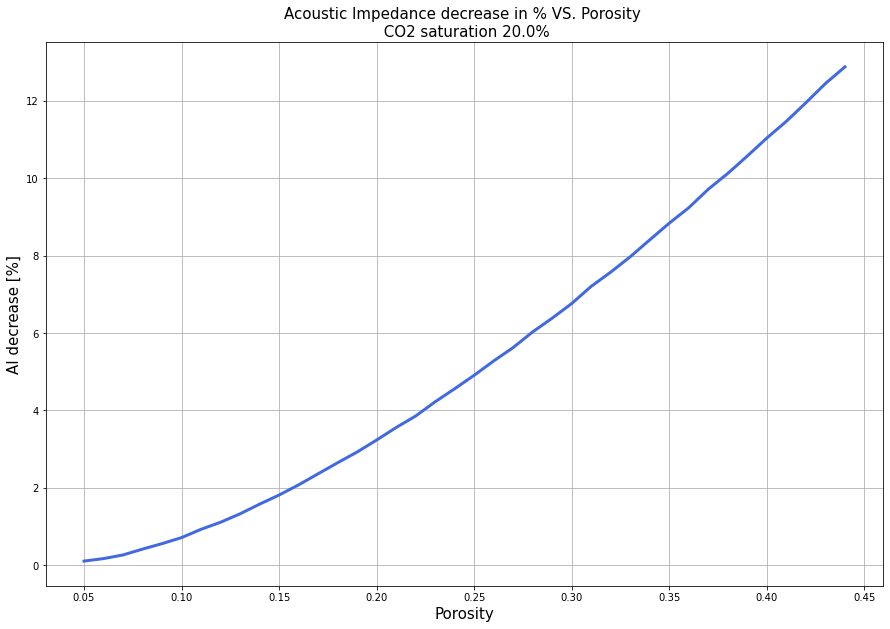

In [219]:
# initialise plot
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(15, 10),sharey=True)

#plot pressure lines
axs.plot(Por, AI_var, color="royalblue", linewidth=3, linestyle="-", label="Acoustic Impedance decrease")

# set plot title and axis labels
axs.set_title(f'Acoustic Impedance decrease in % VS. Porosity \n CO2 saturation {So*100}%', fontsize=15)
axs.set_xlabel('Porosity', fontsize=15)
axs.set_ylabel('AI decrease [%]', fontsize=15)

#show gridlinesb
axs.grid(axis = 'both')


plt.show()

# Uncomment the line below if you would like to save out the plot to a png file
#plt.savefig('plot.png', dpi=300)